In [5]:
import numpy as np
import scipy.linalg

import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.colors import LogNorm
from tqdm import tqdm
import sympy as sp
from scipy.interpolate import pade

In [6]:
PATH = "../latex/pdf/"
# print(plt.rcParams.keys())
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.pad_inches'] = 0
ω = 0.2
λ = 10

def ψ(x, t, ω=0.2, λ=10): #analiticna resitu
    α = np.sqrt(ω)
    ξ_λ = α * λ
    ξ = α * x

    expo = -0.5 * (ξ - ξ_λ*np.cos(ω*t))**2 - 1j * (0.5 * ω*t + ξ*ξ_λ*np.sin(ω*t) - 0.25*ξ_λ**2*np.sin(2*ω*t))
    return np.exp(expo) * np.sqrt(α/np.sqrt(np.pi))

def V(x, k = np.sqrt(ω)):
    return 0.5*x**2*k

def FD(m, n, s):
    x = sp.Symbol('x')
    expr = (x**s * sp.log(x)**m)
    series_exp = sp.series(expr, x, x0=1, n=n+1).removeO()

    dic = sp.collect(sp.expand(series_exp), x).as_coefficients_dict()
    arr = []
    for key in dic:
        base,exp = key.as_base_exp()
        arr.append((exp,dic[key]))
    arr.sort()
    out = []
    for i in arr:
        out.append(float(i[1]))
    return out


def pade_exp(M):
    e_exp = []
    acc = 1
    for i in range(1,2*M+2):
        e_exp.append(1/acc)
        acc *= i
    p, q = pade(e_exp,M)
    return np.roots(p)


x = np.linspace(-40,40,300)
dx = x[1] - x[0]
t = np.linspace(0, 10, 300)
dt = t[1] - t[0]
ψ_0 = ψ(x,0) #initial state


In [7]:
analytic = np.zeros((len(t), len(x)), dtype=complex)
for i in range(0,len(t)):
    t1 = t[i]
    analytic[i] = ψ(x,t1)


In [46]:
Z = []
MM = 8 + 1
NN = 8 + 1
for M in tqdm(range(1,MM,1)):
    Z.append([])
    for N in range(2,NN,2):
        N = 10
        M = 10
        mx=0
        coef = pade_exp(M)
        sol = np.zeros((len(t), len(x)), dtype=complex)
        sol[0] = ψ_0
        Matrices = []
        MatricesC = []
        c = FD(2,N,N//2)
        # print(c)
        for i in range(len(coef)):
            d = (1+1j*dt/coef[i]*V(x))
            A = np.diag(d)
            cof = -1j*dt/2/(dx**2)/coef[i]
            for r in range(len(c)):
                pos = r-N//2
                # print(type(c[r]))
                A += cof*np.diag(c[r]*np.ones(len(x)-abs(pos)),pos)

            Matrices.append(A)
            MatricesC.append(np.conjugate(A))

        A = Matrices[0]
        B = MatricesC[-1]
        for i in range(1,len(Matrices)):
            A = (Matrices[i] @ A)
            B = MatricesC[-i-1] @ B


        for i in range(1,len(sol)):
            sol[i] = np.dot(A, sol[i-1])
            sol[i] = LA.solve(B, sol[i])
            # error = np.abs(np.abs(analytic[i]) - np.abs(sol[i]))
            # error = max(error)
            # if error > 1:
            #     mx = i
            #     print(error)
            #     break
        break
        Z[-1].append(mx)
    break


  0%|          | 0/8 [00:00<?, ?it/s]

/home/arch/faks/mafi-pra/venv/lib/python3.8/site-packages/scipy/interpolate/_pade.py:63: LinAlgWarning: Ill-conditioned matrix (rcond=1.90025e-23): result may not be accurate.
  pq = linalg.solve(C, an)
  0%|          | 0/8 [00:02<?, ?it/s]


[[]]


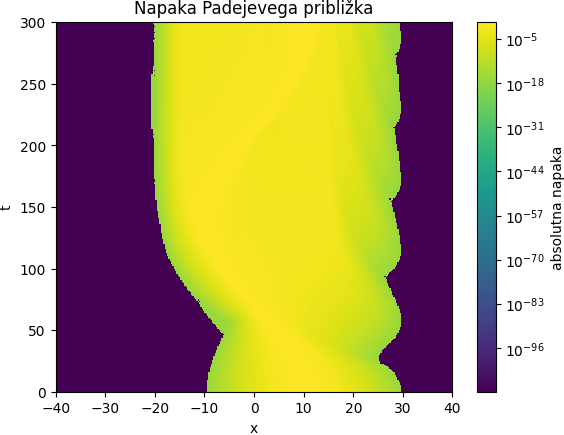

In [52]:
plt.imshow(np.abs(sol[::-1]), interpolation='nearest', extent=[-40,40,0,300], aspect='auto',norm=LogNorm())
print(Z)
plt.colorbar(label="absolutna napaka")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Napaka Padejevega približka")
plt.savefig(PATH+"pade_napake.pdf")